## AI Analyst Mini Demo

In [37]:
import analyst as aiam
question = "What are the top 10 highest runtime movies from 2024?"

### Workflow

#### SQL Generation & Execution

In [3]:
sql_model = "defog/sqlcoder-7b-2"
sql_pipeline = aiam.get_model_pipeline(sql_model)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
sql_prompt = aiam.construct_sql_prompt(question)
print(sql_prompt)

### Task
Generate a PostgreSQL query to answer [QUESTION]What are the top 10 highest runtime movies from 2024?[/QUESTION]

### Instructions
- Use date related fields correctly when provided in different formats
- If you cannot answer the question with the available database schema, return 'I do not know'

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE name_basics (
  nconst TEXT PRIMARY KEY, -- Unique identifier for the name/person
  primaryname TEXT, -- Name by which the person is most often credited
  birthyear INTEGER, -- Birth year integer
  deathyear INTEGER, -- Death year integer
  primaryprofession TEXT, -- Top-3 professions of the person (comma separated for 2 or more)
  knownfortitles TEXT -- Titles the person is known for (comma separated for 2 or more)
);

CREATE TABLE title_akas (
  titleid TEXT, -- Alphanumeric unique identifier of the title (tconst)
  ordering INTEGER, -- Unique ordering for each titleid
  title TEXT, -- Local

In [5]:
sql = aiam.run_inference(sql_pipeline, sql_prompt, task_type='sql')
with open("generted_sql.sql", "w") as file:
    file.write(sql)
print(sql)

SELECT tb.tconst,
       tb.primarytitle,
       tb.runtimeminutes
FROM title_basics tb
WHERE tb.titletype ='movie'
  AND EXTRACT(YEAR
              FROM to_date(tb.startyear::TEXT, 'YYYY')) = 2024
ORDER BY tb.runtimeminutes DESC NULLS LAST
LIMIT 10;


In [6]:
# note about cred file contents
db = aiam.create_db_connection()
df = db.query_to_dataframe(sql)
db.close()
df.head()

Connection established.
Connection closed.


,tconst,primarytitle,runtimeminutes
0,tt32187732,24,1464
1,tt32701008,L'Afrique aux Portes de Paris,1400
2,tt30886362,exergue - on documenta 14,840
3,tt32186666,Tendrils,799
4,tt33776835,Ulysses,587


#### Python Generation & Execution

In [7]:
python_model = "ise-uiuc/Magicoder-S-DS-6.7B"
python_pipeline = aiam.get_model_pipeline(python_model)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
python_prompt = aiam.construct_python_prompt(df, question, sql, avoid_cols=['tconst', 'nconst', 'titleid'])
print(python_prompt)


To answer a question from a user, a dataframe (df) has been created that answers it and now they want a plot.
Create a python function using the columns listed below to make a plot with matplotlib.

df columns to plot (with column type listed for each):
- primarytitle (categorical)
- runtimeminutes (numeric)

Just make one best plot and rotate labels for any categorical columns used on an axis.



In [33]:
python = aiam.run_inference(python_pipeline, python_prompt, task_type='python')
print(python)

def plot_df(df):
    # Create a bar plot for primarytitle and runtimeminutes
    plt.figure(figsize=(10, 6))
    plt.bar(df['primarytitle'], df['runtimeminutes'])
    plt.xlabel('Primary Title')
    plt.ylabel('Runtime Minutes')
    plt.title('Runtime Minutes by Primary Title')
    plt.xticks(rotation=90)
    plt.show()


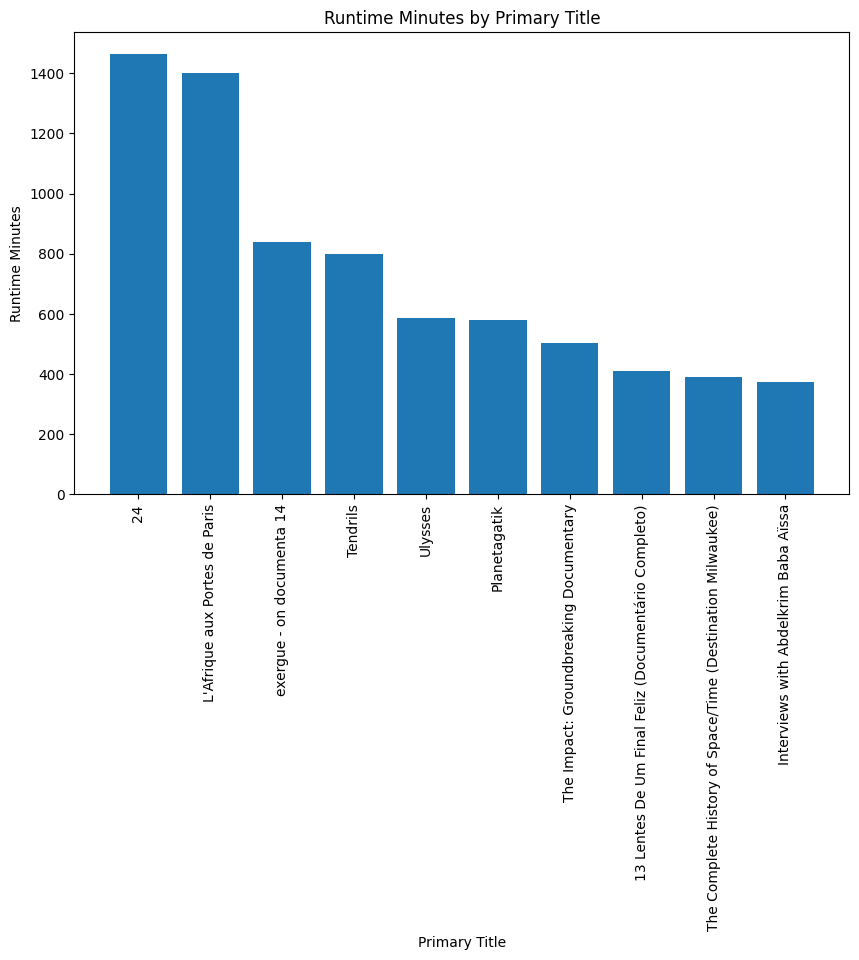

In [34]:
aiam.execute_python_code(python, df)